In [1]:
import re
import itertools
from collections import Counter
import pandas as pd

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wuga/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/wuga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


## Constant

In [2]:
itemID = 'beer/name'
userID = 'user/profileName'
rating = 'review/overall'
reviewText = 'review/text'
dataPath = 'data/beer/advocate/'
dataName = 'RefinedRawData.csv'

## Load Data

In [3]:
df = pd.read_csv(dataPath+dataName, index_col=0)
df.head()

/home/wuga/.local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,beer/ABV,beer/name,beer/style,review/overall,review/text,review/timeUnix,user/profileName
0,5.0,Sausa Weizen,Hefeweizen,1.5,A lot of foam. But a lot.\tIn the smell some b...,1234817823,stcules
1,6.2,Red Moon,English Strong Ale,3.0,"Dark red color, light beige foam, average.\tIn...",1235915097,stcules
2,6.5,Black Horse Black Beer,Foreign / Export Stout,3.0,"Almost totally black. Beige foam, quite compac...",1235916604,stcules
3,5.0,Sausa Pils,German Pilsener,3.0,"Golden yellow color. White, compact foam, quit...",1234725145,stcules
4,7.7,Cauldron DIPA,American Double / Imperial IPA,4.0,"According to the website, the style for the Ca...",1293735206,johnmichaelsen


In [4]:
len(df)

1586614

In [5]:
df = df[~df['user/profileName'].isnull()]

In [6]:
df = df[:100000]

In [7]:
df[df['user/profileName'].isnull()]

,beer/ABV,beer/name,beer/style,review/overall,review/text,review/timeUnix,user/profileName


In [8]:
100000.0/(df[userID].nunique()*df[itemID].nunique())

0.0022676153462229125

## Vectorize

In [9]:
tokenizer = Tokenizer()
df[reviewText] = df[reviewText].apply(lambda x: str(x).replace('\t', ' '))
text = df[reviewText].tolist()
tokenizer.fit_on_texts(text)
# df['vector'] = tokenizer.texts_to_sequences(text)

In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
df_word_index = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word','index'])

In [12]:
#get english stopwords
en_stopwords = set(stopwords.words('english'))

#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords or word.isspace() or word in string.punctuation:
            return False
    for word in ngram:
        if word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    ins = ('IN','TO')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    
    if len(tags) == 2:
        if tags[0][1] in acceptable_types and tags[1][1] in second_type:
            return True
        else:
            return False
    else:
        if tags[0][1] in acceptable_types and tags[2][1] in acceptable_types:
            return True
        else:
            return False
        

In [13]:
stemmer = SnowballStemmer("english")
token_list = (df[reviewText]
              .apply(lambda x: nltk.word_tokenize(x))
              .apply(lambda x: [stemmer.stem(y) for y in x]).tolist())

bigrams = nltk.collocations.BigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)

bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), 
                               columns=['ngram','freq']).sort_values(by='freq', ascending=False)
bigramFreqTable = bigramFreqTable[bigramFreqTable.ngram.map(lambda x: rightTypes(x))]

In [14]:
bigramFreqTable.head()

,ngram,freq
891114,"(white, head)",17919
160842,"(medium, bodi)",13407
187552,"(roast, malt)",10721
19071,"(pint, glass)",9628
224556,"(tan, head)",9273


In [15]:
# trigrams = nltk.collocations.TrigramAssocMeasures()
# tokens = itertools.chain.from_iterable(token_list)
# trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
# trigram_freq = trigramFinder.ngram_fd.items()

# trigramFreqTable = pd.DataFrame(list(trigram_freq), 
#                                 columns=['ngram','freq']).sort_values(by='freq', ascending=False)
# trigramFreqTable = trigramFreqTable[trigramFreqTable.ngram.map(lambda x: rightTypes(x))]

In [16]:
# trigramFreqTable.head(100)

In [17]:
bigramFinder.apply_freq_filter(1000)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                              columns=['ngram','PMI']).sort_values(by='PMI', ascending=False)
bigramPMITable = bigramPMITable[bigramPMITable.ngram.map(lambda x: rightTypes(x))]

In [18]:
bigramPMITable.head()

,ngram,PMI
0,"(west, coast)",12.981848
1,"(sierra, nevada)",10.904224
2,"(mapl, syrup)",10.579920
6,"(barrel, age)",9.502039
8,"(breakfast, stout)",9.170152


In [19]:
df_keyphrases = pd.merge(bigramPMITable, bigramFreqTable, how='left', on='ngram')

In [20]:
df_keyphrases = df_keyphrases[df_keyphrases['freq']<=5000][:100]
df_keyphrases.head()

,ngram,PMI,freq
0,"(west, coast)",12.981848,1075
2,"(mapl, syrup)",10.579920,1955
3,"(barrel, age)",9.502039,1538
4,"(breakfast, stout)",9.170152,1082
5,"(orang, peel)",8.942758,1283


In [21]:
#df_keyphrases = pd.concat([bigramFreqTable[['ngram']][10:90], trigramFreqTable[['ngram']].head(10)])
#df_keyphrases = bigramFreqTable[['ngram']].head(100)
df_keyphrases['Phrases'] = df_keyphrases['ngram'].apply(lambda x: ' '.join(x))
df_keyphrases = df_keyphrases[['Phrases']].reset_index(drop=True)
keyphrases = df_keyphrases['Phrases'].tolist()

In [22]:
df['keyVector'] = df[reviewText].apply(lambda x: [i for i,key in enumerate(keyphrases) if key in x])

In [23]:
df['UserIndex'] = df[userID].astype('category').cat.rename_categories(range(0, df[userID].nunique()))
df['ItemIndex'] = df[itemID].astype('category').cat.rename_categories(range(0, df[itemID].nunique()))
df['Binary'] = (df[rating] > 4)*1

In [24]:
df_user_name = df[['UserIndex',userID]]
df_item_name = df[['ItemIndex',itemID]]

In [25]:
df = df.drop([itemID, userID, reviewText], axis=1)

## DataFrames

In [26]:
df.head(50)

,beer/ABV,beer/style,review/overall,review/timeUnix,keyVector,UserIndex,ItemIndex,Binary
0,5.0,Hefeweizen,1.5,1234817823,[],10908,2811,0
1,6.2,English Strong Ale,3.0,1235915097,[],10908,2652,0
2,6.5,Foreign / Export Stout,3.0,1235916604,[],10908,463,0
3,5.0,German Pilsener,3.0,1234725145,[40],10908,2810,0
4,7.7,American Double / Imperial IPA,4.0,1293735206,"[21, 41, 72]",8279,709,0
5,4.7,Herbed / Spiced Beer,3.0,1325524659,[],9728,669,0
6,4.7,Herbed / Spiced Beer,3.5,1318991115,[18],3749,669,0
7,4.7,Herbed / Spiced Beer,3.0,1306276018,"[57, 65]",5099,669,0
8,4.7,Herbed / Spiced Beer,4.0,1290454503,[30],2833,669,0
9,4.7,Herbed / Spiced Beer,4.5,1285632924,"[83, 90]",5246,669,1


In [27]:
df_word_index.head()

,word,index
0,fawn,32719
1,hoppinglight,39929
2,piazza's,36037
3,lagermalt,51050
4,woods,3775


In [28]:
df_keyphrases.head(50)

,Phrases
0,west coast
1,mapl syrup
2,barrel age
3,breakfast stout
4,orang peel
5,imperi stout
6,tropic fruit
7,belgian yeast
8,high recommend
9,milk chocol


In [29]:
df_user_name.head()

,UserIndex,user/profileName
0,10908,stcules
1,10908,stcules
2,10908,stcules
3,10908,stcules
4,8279,johnmichaelsen


In [30]:
df_item_name.head()

,ItemIndex,beer/name
0,2811,Sausa Weizen
1,2652,Red Moon
2,463,Black Horse Black Beer
3,2810,Sausa Pils
4,709,Cauldron DIPA


## Statistic

In [31]:
print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
print("Number of Positive Review: {0}".format(sum(df['Binary'].tolist())))

Number of User: 11951
Number of Item: 3690
Number of Positive Review: 30033


In [32]:
review_lengths = df.keyVector.apply(lambda x: len(x)).tolist()

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


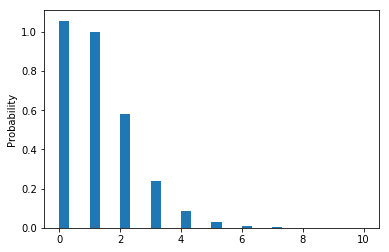

In [33]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(review_lengths, normed=True, bins=30)
plt.ylabel('Probability');

In [34]:
df['ItemIndex'].value_counts()[:50]

2898    2999
2914    2587
1174    2501
2892    2491
2929    2029
1228    1930
1253    1405
1178    1394
2283    1353
2927    1322
1515    1268
2507    1257
1195    1257
2917    1253
2925    1230
1199    1164
2923    1145
1227    1078
1194    1066
2910    1021
1148    1020
2885    1002
1250     900
87       889
2906     873
2930     870
238      834
1191     777
3112     735
3113     701
1215     674
1986     674
1175     637
44       624
1248     616
2904     611
2157     588
88       574
1689     556
1179     489
2344     486
174      465
1239     460
2932     450
46       432
232      431
1238     429
1053     408
1166     403
289      395
Name: ItemIndex, dtype: int64

In [35]:
len(df[df['review/overall'] > 4])

30033

In [36]:
df['Binary'] = (df[rating] > 4)*1

## Save

In [37]:
df.to_csv(dataPath+'Data.csv')
df_word_index.to_csv(dataPath+'WordIndex.csv')
df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
df_user_name.to_csv(dataPath+'UserIndex.csv')
df_item_name.to_csv(dataPath+'ItemIndex.csv')

In [38]:
# may be we need to use the pretrained user item embedding